In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import invgamma
import scipy.integrate as integrate
import scipy.optimize as opt
import emcee
import corner

In [25]:
# read the supernova (cosmological) redshift data
datafile = open('SCPUnion2.1_mu_vs_z.txt','r')
SCP_data = pd.read_table(datafile,comment='#',
                        names=['SN name','Redshift','Distance modulus',
                                   'Distance modulus error','P low mass'])
print(SCP_data)

    SN name  Redshift  Distance modulus  Distance modulus error  P low mass
0    1993ah  0.028488         35.346583                0.223906    0.128419
1    1993ag  0.050043         36.682368                0.166829    0.128419
2     1993o  0.052926         36.817691                0.155756    0.128419
3     1993b  0.070086         37.446737                0.158467    0.128419
4    1992bs  0.062668         37.483409                0.156099    0.128419
..      ...       ...               ...                     ...         ...
575   D-000  1.017000         44.293971                0.171046    0.000015
576   D-006  1.315000         44.971358                0.187509    0.551672
577   P-009  0.821000         43.640939                0.194014    0.551672
578   R-012  1.215000         45.246521                0.560317    0.000148
579   Z-005  0.623000         42.514524                0.241428    0.551672

[580 rows x 5 columns]


In [26]:
filename = 'SCPUnion2.1_mu_vs_z.txt'

# Load the data from the file
data = np.loadtxt(filename, usecols=(1, 2, 3, 4), skiprows = 5)
Nd = 580
c = 299792.458
alpha = 0.121851859725
beta = 2.46569277393

z = data[:, 0] # size: 580x1
low = z < 0.5
mu = data[:, 1]
mu_error = data[:, 2]
P_low_mass = data[:, 3]
dl = 10**(mu/5-5)
dl_error = 10**(mu/5-5)*(10**(mu_error/5) - 1)

low_z = z[low] # size: 412x1
low_mu = mu[low]
low_mu_error = mu_error[low]
low_P_low_mass = P_low_mass[low]
low_dl = 10**(low_mu/5-5)
low_dl_error = dl_error[low]

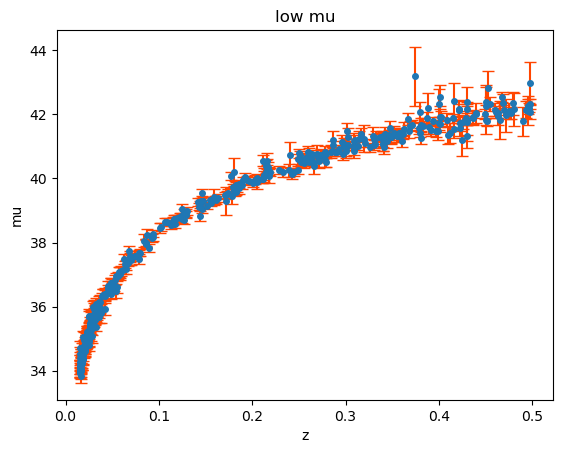

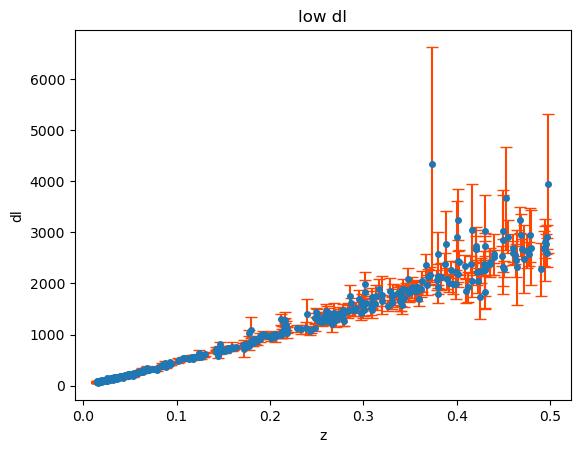

In [27]:
plt.figure(1)
plt.errorbar(low_z, low_mu, yerr=low_mu_error, fmt='o', ecolor='orangered', capsize=4, linestyle='None', markersize=4)
plt.xlabel('z')
plt.ylabel('mu')
plt.title('low mu')

plt.show()

plt.figure(2)
plt.errorbar(low_z, low_dl, yerr=low_dl_error, fmt='o', ecolor='orangered', capsize=4, linestyle='None', markersize=4)
plt.xlabel('z')
plt.ylabel('dl')
plt.title('low dl')

plt.show()

In [54]:
# Normerade vikter.
W = np.square(1/low_dl_error)
Nw = np.sum(W)/Nd
W = W/Nw
print(np.prod(W))

0.0


In [29]:
def dl_model(H0, q0, z):
    return c / H0 * (z + 0.5 * (1-q0) * z**2)

In [58]:
def log_likelihood(param, z, dl, W):
    H0, q0, sig2 = param
    n = len(dl)
    return -0.5 * (np.sum((dl - dl_model(H0, q0, z))**2 * W / sig2)) - (n/2)*np.log(sig2)

def log_prior(sig2):
    if sig2 > 1e-16:
        return invgamma.logpdf(sig2, a = alpha, scale = beta) 
    else:
        return -np.inf

def log_posterior(param, z, dl, W):
    lp = log_prior(param[-1])
    if not np.isfinite(lp):
        return -np.inf
    ll = log_likelihood(param, z, dl, W)
    return ll + lp

In [44]:
def simple_mcmc_analysis(sampler, par, label, burn_in):

    print(f'Mean acceptance fraction: {np.mean(sampler.acceptance_fraction):0.3f}')
    # discard the first 'burn_in' samples 
    
    # thinning means that you only keep every nth sample. E.g. thinning=10 -> keep every 10th sample.
    # This can be useful for reducing long autocorrelation lenghts in a chain. However, thinning is expensive.
    # A thinned chain must be run E.g. 10x longer to reach the desired number of samples.
    # One can argue that thinning is not an advantageous strategy. So keep thinning = 1
    thinning = 1
    flat_mcmc_samples = sampler.get_chain(discard=burn_in,thin=thinning, flat=True)
    print(f'Discarding {nwalkers*burn_in} steps as burn-in')
    print(f'Chain length:{len(flat_mcmc_samples)}')

    fig1 = plt.figure();
    plt.plot(flat_mcmc_samples[:,par],color='gray',alpha=0.7)
    plt.xlabel('Sample');
    plt.ylabel(label)
    plt.xlim(0,len(flat_mcmc_samples));

    return flat_mcmc_samples

In [59]:
ndim, nwalkers = 3, 10
start_pos = [70, -0.4, 251] + 1e-3 * np.random.randn(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(low_z, low_dl, W))
sampler.run_mcmc(start_pos, 2000, progress=True)

100%|██████████| 2000/2000 [00:17<00:00, 111.86it/s]


State([[ 70.10412151  -0.34009599 259.50275688]
 [ 70.15550963  -0.45191858 249.90368846]
 [ 69.90918067  -0.33050632 258.65258417]
 [ 70.25956908  -0.37586908 242.2262478 ]
 [ 70.01553466  -0.37402932 234.70760059]
 [ 69.73665593  -0.34210167 254.22463031]
 [ 69.85952598  -0.42421637 272.87767921]
 [ 70.20268417  -0.36627762 248.91814413]
 [ 69.96932337  -0.44034722 244.27593425]
 [ 70.64911212  -0.50298433 225.55718481]], log_prob=[-1352.33166506 -1352.38202236 -1352.19695736 -1351.78362744
 -1351.8902874  -1352.23777631 -1354.03566602 -1351.76151622
 -1353.2091937  -1353.42804583], blobs=None, random_state=('MT19937', array([2376439731, 1611987483, 2446328535, 3620896709, 3718578685,
       3563794243,  476082115, 2268657821, 3672288854, 2209211184,
       1227473465, 4064701264, 1480924256, 3986817114, 3387199003,
       2621224341, 3480341408, 2434527040, 2386000723, 1742907562,
       1331109583,  668481727, 4185546958,  530569891, 1069362833,
        438400243, 4041406209,   768

Mean acceptance fraction: 0.651
Discarding 5000 steps as burn-in
Chain length:15000


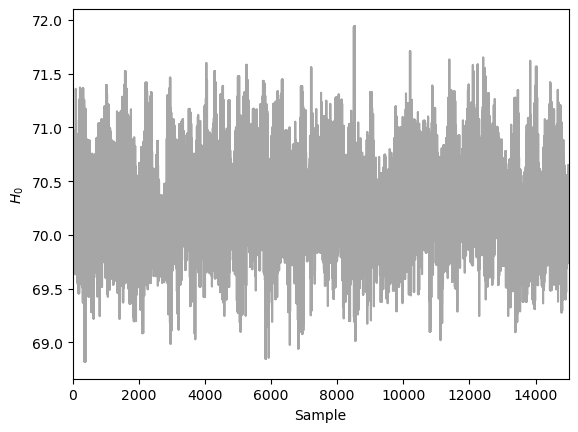

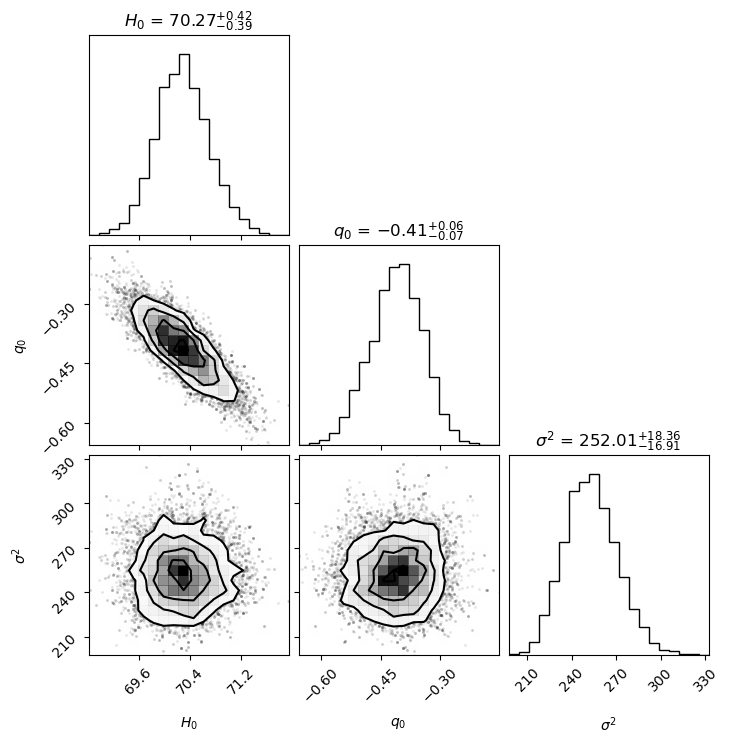

In [60]:
flat_mcmc_samples = simple_mcmc_analysis(sampler, par=0, label=f'$H_0$', burn_in=500)

fig = corner.corner(flat_mcmc_samples,labels=[r"$H_0$", r"$q_0$", r"$\sigma^2$"],show_titles=True)

In [11]:
# medelvärden
H0_mean, q0_mean, sig2_mean = np.array([np.mean(flat_mcmc_samples[:,k]) for k in range(0,len(flat_mcmc_samples[0]))])

H0 = flat_mcmc_samples[:,0]
q0 = flat_mcmc_samples[:,1]
sig2 = flat_mcmc_samples[:,2]

z_lin = np.linspace(0,0.5, 1000)
res_d = np.empty(1000)
res_d_min = np.empty(1000)
res_d_max = np.empty(1000)
for i,z in enumerate(z_lin):
    vec = dl_model(H0, q0, z)
    res_d[i] = np.mean(vec)
    res_d_min[i] = np.percentile(vec, 45)
    res_d_max[i] = np.percentile(vec,55)

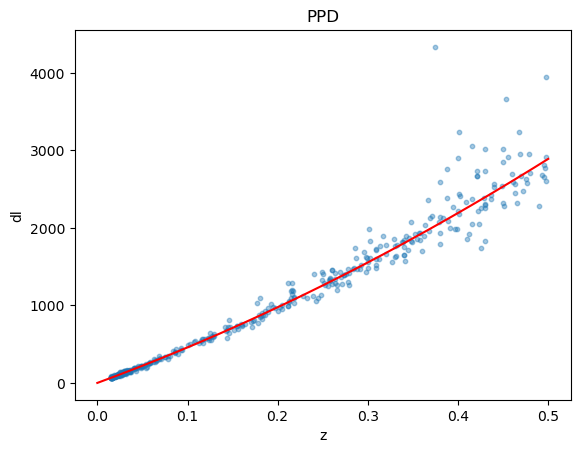

In [12]:
plt.figure(3)
plt.scatter(low_z, low_dl, s=10, alpha=0.4)
plt.plot(z_lin, res_d, c='r')
plt.fill_between(z_lin, res_d_min, res_d_max, alpha = 0.4)
plt.xlabel('z')
plt.ylabel('dl')
plt.title('PPD')

plt.show()

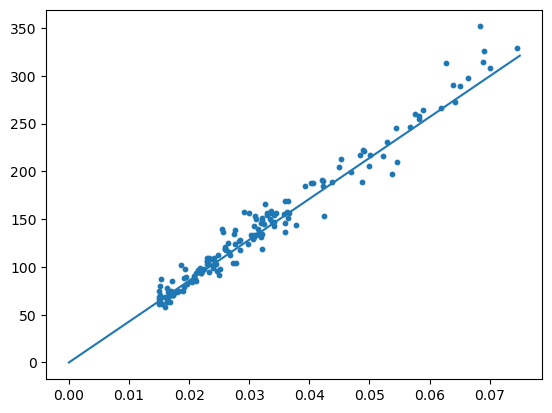

In [13]:
lower_z = low_z[low_z < 0.075]
lower_dl = low_dl[low_z < 0.075]
z_lower_lin = np.linspace(0, 0.075, 500)

plt.figure(4)
plt.scatter(lower_z, lower_dl, s=10)
plt.plot(z_lower_lin, z_lower_lin*c/H0_mean)

In [14]:
# Task 2

In [120]:
H0 = 70 #Km/s/Mpc
c = 300000 #km/s

def E_z(z, Omega_M0, w):
    return Omega_M0*(1+z)**3 + (1-Omega_M0)*(1+z)**(3*(1+w))

def H_wCDM(z, Omega_M0, w):
    return H0*np.sqrt(E_z(z, Omega_M0, w))

def H_LCDM(z, Omega_M0):
    return H_wCDM(Omega_M0, z, -1)

def integrand(z,H,Omega_M0, w):
    return 1/H(z,Omega_M0, w)

def dl_15(Omega_M0, w, H, z):
    #Omega_M0, w = params
    #f = lambda z, Omega_M0, w: 1/H(z, Omega_M0, w)
    arr = np.empty(len(z))
    for i, z_i in enumerate(z):
        res = integrate.quad(integrand, 0, z_i, args=(H, Omega_M0, w))
        #print(type(res[0]))
        arr[i] = c*(1+z_i)/H0*res[0]
    return arr

def neg_log_likelihood(Omega_M0, w, H, z, dl, W):
    n = len(dl)
    #print(+0.5 * (np.sum((dl - dl_15(w, Omega_M0, H, z))**2 * n * W)))
    return +0.5 * (np.sum((dl - dl_15(Omega_M0, w, H, z))**2 * W))

def wls(phi, W, d):
    inv_factor = np.linalg.inv(np.matmul(np.transpose(phi), np.matmul(W, phi)))
    factor = np.matmul(np.transpose(phi), np.matmul(W, d))
    return np.matmul(inv_factor, factor)

In [122]:
W = np.square(1/dl_error)
Nw = np.sum(W)/Nd
W = W/Nw

Omega_L0 = 0.6889 
Omega_M0 = 0.29
#initial_guess = np.array([0.4, -1])
initial_guess = 0.29
#print(initial_guess)
#print(integrate.quad(integrand, 0, z, args=(H_wCDM, Omega_M0, -1)))
#print(dl_15(-1,Omega_M0, H_wCDM, z))
#print(neg_log_likelihood(-1,0.29,H_wCDM,z,dl,W))

#LCDM = 

#LCDM.fun

arr_w = np.linspace(-2,2,10)
BIC = np.empty(len(arr_w))
for i,w in enumerate(arr_w):
    BIC[i] =
    #opt.minimize(neg_log_likelihood, initial_guess, args=(w, H_wCDM, z, dl, W)) #-2*neg_log_likelihood(w,Omega_M0,H_wCDM,z,dl,W)-np.log(Nd)
    print(f"Finished with {w}")
fig = plt.figure()
plt.plot(arr_w, BIC)
plt.show()

C:\Users\Elsa3\AppData\Local\Temp\ipykernel_25828\58205974.py:8: RuntimeWarning: invalid value encountered in sqrt
  return H0*np.sqrt(E_z(z, Omega_M0, w))
C:\Users\Elsa3\AppData\Local\Temp\ipykernel_25828\58205974.py:21: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  res = integrate.quad(integrand, 0, z_i, args=(H, Omega_M0, w))


KeyboardInterrupt: 